In [1]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 


train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

test_id=test_df["ID_code"]

# var3 피처 값 대체 및 ID 피처 드롭
train_df.drop('ID_code',axis=1 , inplace=True)
test_df.drop('ID_code',axis=1 , inplace=True)


train = train_df.iloc[:, 1:]
y_labels = train_df.iloc[:, -0]



from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2).fit(train)
X_features = poly.transform(train)

print("X_train.shape: {}".format(train_df.shape))
print("X_train.shape: {}".format(y_labels.shape))
print('피처 데이터 shape:{0}'.format(X_features.shape))

X_train.shape: (200000, 201)
X_train.shape: (200000,)
피처 데이터 shape:(200000, 20301)


In [2]:
X_features=pd.DataFrame(X_features,columns=poly.get_feature_names())
X_features.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x196^2,x196 x197,x196 x198,x196 x199,x197^2,x197 x198,x197 x199,x198^2,x198 x199,x199^2
0,1.0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,62.069187,67.466678,100.688316,-8.598486,73.333532,109.444099,-9.346204,163.336068,-13.948419,1.191154
1,1.0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,66.043253,71.424754,149.173705,15.861693,77.244763,161.329048,17.154175,336.942736,35.827241,3.809523
2,1.0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,42.527354,-53.914848,-96.007883,-2.585695,68.351556,121.715789,3.278064,216.743173,5.837352,0.157212
3,1.0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,8.570256,-30.130416,-52.606297,26.346329,105.929381,184.947746,-92.625683,322.910118,-161.720112,80.992800
4,1.0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,15.418973,37.315823,70.670391,-34.595798,90.308910,171.031092,-83.726112,323.906407,-158.564293,77.623148


# 20301 중 201:700

In [3]:
X_features=X_features.iloc[:,201:700]
X_features=pd.concat([train,X_features],axis=1)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
val_cnt = y_val.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1},검증 세트 Shape:{2}'.format(X_train.shape , X_test.shape, X_val.shape ))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)
print('\n 검증 세트 레이블 값 분포 비율')
print(y_val.value_counts()/val_cnt)

학습 세트 Shape:(128000, 699), 테스트 세트 Shape:(40000, 699),검증 세트 Shape:(32000, 699)
 학습 세트 레이블 값 분포 비율
0    0.899398
1    0.100602
Name: target, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.89965
1    0.10035
Name: target, dtype: float64

 검증 세트 레이블 값 분포 비율
0    0.899781
1    0.100219
Name: target, dtype: float64


In [6]:
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(    
    n_estimators=10000,
    boost_from_average= False,
    boost= 'gbdt',
    learning_rate= 0.03,
    max_depth= -1,
    metric='auc',
    objective= 'binary', 
    verbosity= -1
)

evals = [(X_train, y_train),(X_val, y_val)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)


lgbm_roc_score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1],average='macro')
lgbm_roc_score1 = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('검증셋 ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('테스트셋 ROC AUC: {0:.4f}'.format(lgbm_roc_score1))

[1]	training's auc: 0.683914	valid_1's auc: 0.660052
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.688622	valid_1's auc: 0.665383
[3]	training's auc: 0.70247	valid_1's auc: 0.677159
[4]	training's auc: 0.71249	valid_1's auc: 0.687745
[5]	training's auc: 0.723811	valid_1's auc: 0.699262
[6]	training's auc: 0.724815	valid_1's auc: 0.698625
[7]	training's auc: 0.729365	valid_1's auc: 0.702129
[8]	training's auc: 0.734113	valid_1's auc: 0.706262
[9]	training's auc: 0.736415	valid_1's auc: 0.707247
[10]	training's auc: 0.737541	valid_1's auc: 0.708454
[11]	training's auc: 0.741365	valid_1's auc: 0.711636
[12]	training's auc: 0.743968	valid_1's auc: 0.713329
[13]	training's auc: 0.748162	valid_1's auc: 0.717249
[14]	training's auc: 0.750568	valid_1's auc: 0.719257
[15]	training's auc: 0.750728	valid_1's auc: 0.718805
[16]	training's auc: 0.752994	valid_1's auc: 0.72028
[17]	training's auc: 0.75503	valid_1's auc: 0.722725
[18]	training's auc: 0.757044	va

[152]	training's auc: 0.883805	valid_1's auc: 0.826854
[153]	training's auc: 0.884322	valid_1's auc: 0.827038
[154]	training's auc: 0.884857	valid_1's auc: 0.827546
[155]	training's auc: 0.885431	valid_1's auc: 0.827884
[156]	training's auc: 0.885843	valid_1's auc: 0.828278
[157]	training's auc: 0.886308	valid_1's auc: 0.828656
[158]	training's auc: 0.886737	valid_1's auc: 0.828945
[159]	training's auc: 0.887288	valid_1's auc: 0.829278
[160]	training's auc: 0.887631	valid_1's auc: 0.829589
[161]	training's auc: 0.888056	valid_1's auc: 0.830088
[162]	training's auc: 0.888489	valid_1's auc: 0.83046
[163]	training's auc: 0.888866	valid_1's auc: 0.830682
[164]	training's auc: 0.889221	valid_1's auc: 0.830995
[165]	training's auc: 0.889656	valid_1's auc: 0.831362
[166]	training's auc: 0.89012	valid_1's auc: 0.831783
[167]	training's auc: 0.89042	valid_1's auc: 0.832117
[168]	training's auc: 0.890968	valid_1's auc: 0.832545
[169]	training's auc: 0.891474	valid_1's auc: 0.832902
[170]	trainin

[302]	training's auc: 0.929655	valid_1's auc: 0.859762
[303]	training's auc: 0.929882	valid_1's auc: 0.859946
[304]	training's auc: 0.930117	valid_1's auc: 0.860095
[305]	training's auc: 0.930303	valid_1's auc: 0.860217
[306]	training's auc: 0.930487	valid_1's auc: 0.86034
[307]	training's auc: 0.930697	valid_1's auc: 0.860453
[308]	training's auc: 0.93089	valid_1's auc: 0.860516
[309]	training's auc: 0.931005	valid_1's auc: 0.860645
[310]	training's auc: 0.931247	valid_1's auc: 0.860748
[311]	training's auc: 0.931425	valid_1's auc: 0.860877
[312]	training's auc: 0.93161	valid_1's auc: 0.861008
[313]	training's auc: 0.931787	valid_1's auc: 0.861184
[314]	training's auc: 0.931889	valid_1's auc: 0.861181
[315]	training's auc: 0.932105	valid_1's auc: 0.861302
[316]	training's auc: 0.93232	valid_1's auc: 0.861393
[317]	training's auc: 0.932451	valid_1's auc: 0.861574
[318]	training's auc: 0.932634	valid_1's auc: 0.861812
[319]	training's auc: 0.932878	valid_1's auc: 0.861972
[320]	training

[452]	training's auc: 0.951539	valid_1's auc: 0.873111
[453]	training's auc: 0.951629	valid_1's auc: 0.873144
[454]	training's auc: 0.951734	valid_1's auc: 0.873194
[455]	training's auc: 0.951865	valid_1's auc: 0.873268
[456]	training's auc: 0.95197	valid_1's auc: 0.873343
[457]	training's auc: 0.952077	valid_1's auc: 0.873397
[458]	training's auc: 0.952186	valid_1's auc: 0.87346
[459]	training's auc: 0.952295	valid_1's auc: 0.873522
[460]	training's auc: 0.952394	valid_1's auc: 0.873601
[461]	training's auc: 0.952511	valid_1's auc: 0.873657
[462]	training's auc: 0.952616	valid_1's auc: 0.873718
[463]	training's auc: 0.952737	valid_1's auc: 0.873805
[464]	training's auc: 0.952834	valid_1's auc: 0.873893
[465]	training's auc: 0.952934	valid_1's auc: 0.873968
[466]	training's auc: 0.953057	valid_1's auc: 0.874026
[467]	training's auc: 0.95316	valid_1's auc: 0.874061
[468]	training's auc: 0.953263	valid_1's auc: 0.874091
[469]	training's auc: 0.953347	valid_1's auc: 0.874123
[470]	trainin

[602]	training's auc: 0.964765	valid_1's auc: 0.879355
[603]	training's auc: 0.964859	valid_1's auc: 0.879389
[604]	training's auc: 0.964916	valid_1's auc: 0.879426
[605]	training's auc: 0.964986	valid_1's auc: 0.879416
[606]	training's auc: 0.965051	valid_1's auc: 0.879446
[607]	training's auc: 0.965116	valid_1's auc: 0.879465
[608]	training's auc: 0.96517	valid_1's auc: 0.879519
[609]	training's auc: 0.965227	valid_1's auc: 0.879561
[610]	training's auc: 0.965297	valid_1's auc: 0.879624
[611]	training's auc: 0.96537	valid_1's auc: 0.879657
[612]	training's auc: 0.965425	valid_1's auc: 0.879686
[613]	training's auc: 0.965487	valid_1's auc: 0.879733
[614]	training's auc: 0.96556	valid_1's auc: 0.879779
[615]	training's auc: 0.965618	valid_1's auc: 0.879832
[616]	training's auc: 0.965684	valid_1's auc: 0.879912
[617]	training's auc: 0.96576	valid_1's auc: 0.879897
[618]	training's auc: 0.965832	valid_1's auc: 0.879915
[619]	training's auc: 0.96589	valid_1's auc: 0.879978
[620]	training'

[752]	training's auc: 0.97417	valid_1's auc: 0.883463
[753]	training's auc: 0.974231	valid_1's auc: 0.88349
[754]	training's auc: 0.974293	valid_1's auc: 0.883508
[755]	training's auc: 0.974332	valid_1's auc: 0.883542
[756]	training's auc: 0.974395	valid_1's auc: 0.883587
[757]	training's auc: 0.974435	valid_1's auc: 0.883598
[758]	training's auc: 0.974485	valid_1's auc: 0.883589
[759]	training's auc: 0.974544	valid_1's auc: 0.883646
[760]	training's auc: 0.974604	valid_1's auc: 0.883626
[761]	training's auc: 0.974642	valid_1's auc: 0.883663
[762]	training's auc: 0.974696	valid_1's auc: 0.883679
[763]	training's auc: 0.974749	valid_1's auc: 0.883691
[764]	training's auc: 0.974811	valid_1's auc: 0.883691
[765]	training's auc: 0.974864	valid_1's auc: 0.883703
[766]	training's auc: 0.974924	valid_1's auc: 0.883776
[767]	training's auc: 0.974987	valid_1's auc: 0.883786
[768]	training's auc: 0.975044	valid_1's auc: 0.883797
[769]	training's auc: 0.975089	valid_1's auc: 0.883808
[770]	traini

[902]	training's auc: 0.981461	valid_1's auc: 0.885951
[903]	training's auc: 0.981501	valid_1's auc: 0.885979
[904]	training's auc: 0.981538	valid_1's auc: 0.885991
[905]	training's auc: 0.981581	valid_1's auc: 0.885979
[906]	training's auc: 0.981646	valid_1's auc: 0.88598
[907]	training's auc: 0.981672	valid_1's auc: 0.885995
[908]	training's auc: 0.981704	valid_1's auc: 0.88603
[909]	training's auc: 0.981753	valid_1's auc: 0.88603
[910]	training's auc: 0.981799	valid_1's auc: 0.886061
[911]	training's auc: 0.98185	valid_1's auc: 0.8861
[912]	training's auc: 0.981891	valid_1's auc: 0.886125
[913]	training's auc: 0.981923	valid_1's auc: 0.886128
[914]	training's auc: 0.981963	valid_1's auc: 0.886104
[915]	training's auc: 0.982001	valid_1's auc: 0.886135
[916]	training's auc: 0.98205	valid_1's auc: 0.886147
[917]	training's auc: 0.982088	valid_1's auc: 0.88618
[918]	training's auc: 0.982126	valid_1's auc: 0.886178
[919]	training's auc: 0.982166	valid_1's auc: 0.886226
[920]	training's a

[1052]	training's auc: 0.986877	valid_1's auc: 0.88763
[1053]	training's auc: 0.986912	valid_1's auc: 0.887622
[1054]	training's auc: 0.986933	valid_1's auc: 0.887606
[1055]	training's auc: 0.98696	valid_1's auc: 0.887621
[1056]	training's auc: 0.986992	valid_1's auc: 0.887612
[1057]	training's auc: 0.987036	valid_1's auc: 0.887624
[1058]	training's auc: 0.98707	valid_1's auc: 0.88763
[1059]	training's auc: 0.987087	valid_1's auc: 0.887632
[1060]	training's auc: 0.987107	valid_1's auc: 0.887651
[1061]	training's auc: 0.987143	valid_1's auc: 0.887659
[1062]	training's auc: 0.987167	valid_1's auc: 0.887694
[1063]	training's auc: 0.987192	valid_1's auc: 0.887712
[1064]	training's auc: 0.987216	valid_1's auc: 0.887744
[1065]	training's auc: 0.987254	valid_1's auc: 0.887732
[1066]	training's auc: 0.987291	valid_1's auc: 0.887741
[1067]	training's auc: 0.987324	valid_1's auc: 0.887759
[1068]	training's auc: 0.987348	valid_1's auc: 0.887762
[1069]	training's auc: 0.987391	valid_1's auc: 0.887

[1200]	training's auc: 0.99079	valid_1's auc: 0.888639
[1201]	training's auc: 0.990817	valid_1's auc: 0.888628
[1202]	training's auc: 0.990834	valid_1's auc: 0.888631
[1203]	training's auc: 0.990861	valid_1's auc: 0.888629
[1204]	training's auc: 0.990885	valid_1's auc: 0.888635
[1205]	training's auc: 0.9909	valid_1's auc: 0.888633
[1206]	training's auc: 0.990913	valid_1's auc: 0.888633
[1207]	training's auc: 0.990932	valid_1's auc: 0.888624
[1208]	training's auc: 0.990949	valid_1's auc: 0.888632
[1209]	training's auc: 0.990967	valid_1's auc: 0.888634
[1210]	training's auc: 0.990983	valid_1's auc: 0.888642
[1211]	training's auc: 0.991007	valid_1's auc: 0.888639
[1212]	training's auc: 0.991021	valid_1's auc: 0.888643
[1213]	training's auc: 0.991039	valid_1's auc: 0.888628
[1214]	training's auc: 0.99107	valid_1's auc: 0.888623
[1215]	training's auc: 0.991103	valid_1's auc: 0.88862
[1216]	training's auc: 0.991129	valid_1's auc: 0.888633
[1217]	training's auc: 0.991153	valid_1's auc: 0.8886

[1348]	training's auc: 0.993667	valid_1's auc: 0.88867
[1349]	training's auc: 0.99368	valid_1's auc: 0.888656
[1350]	training's auc: 0.993695	valid_1's auc: 0.888649
[1351]	training's auc: 0.993711	valid_1's auc: 0.888676
[1352]	training's auc: 0.993735	valid_1's auc: 0.888664
[1353]	training's auc: 0.993755	valid_1's auc: 0.888655
[1354]	training's auc: 0.993765	valid_1's auc: 0.888656
[1355]	training's auc: 0.993783	valid_1's auc: 0.888671
[1356]	training's auc: 0.993796	valid_1's auc: 0.8887
[1357]	training's auc: 0.993822	valid_1's auc: 0.8887
[1358]	training's auc: 0.993837	valid_1's auc: 0.888694
[1359]	training's auc: 0.993847	valid_1's auc: 0.88868
[1360]	training's auc: 0.993861	valid_1's auc: 0.88868
[1361]	training's auc: 0.993878	valid_1's auc: 0.888682
[1362]	training's auc: 0.993894	valid_1's auc: 0.888699
[1363]	training's auc: 0.993904	valid_1's auc: 0.888706
[1364]	training's auc: 0.99392	valid_1's auc: 0.888728
[1365]	training's auc: 0.993939	valid_1's auc: 0.888728
[

[1496]	training's auc: 0.995696	valid_1's auc: 0.888705
[1497]	training's auc: 0.995718	valid_1's auc: 0.888714
[1498]	training's auc: 0.99573	valid_1's auc: 0.888713
[1499]	training's auc: 0.995741	valid_1's auc: 0.888706
[1500]	training's auc: 0.995757	valid_1's auc: 0.888702
[1501]	training's auc: 0.995766	valid_1's auc: 0.888698
[1502]	training's auc: 0.99578	valid_1's auc: 0.888695
[1503]	training's auc: 0.995789	valid_1's auc: 0.888665
[1504]	training's auc: 0.995802	valid_1's auc: 0.888678
[1505]	training's auc: 0.995812	valid_1's auc: 0.888682
[1506]	training's auc: 0.995822	valid_1's auc: 0.888675
[1507]	training's auc: 0.995833	valid_1's auc: 0.888671
[1508]	training's auc: 0.995839	valid_1's auc: 0.888673
[1509]	training's auc: 0.99585	valid_1's auc: 0.888663
[1510]	training's auc: 0.995864	valid_1's auc: 0.888652
[1511]	training's auc: 0.995876	valid_1's auc: 0.888671
[1512]	training's auc: 0.995891	valid_1's auc: 0.888667
[1513]	training's auc: 0.995907	valid_1's auc: 0.88

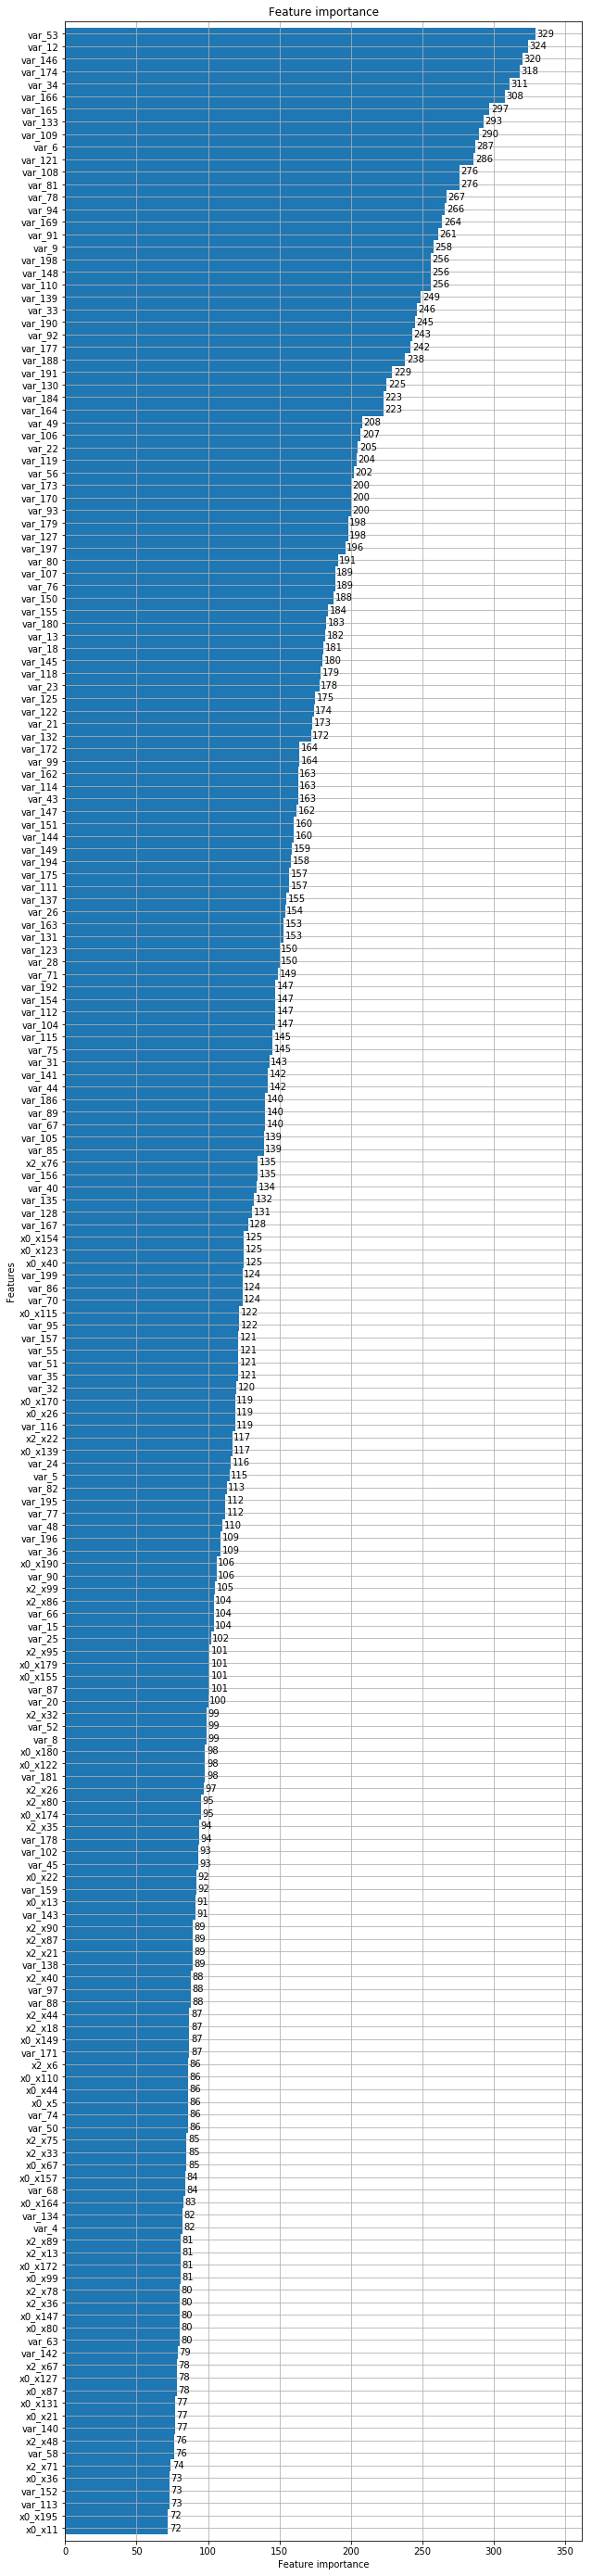

In [12]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,50))
plot_importance(lgbm_clf, ax=ax , max_num_features=200,height=1)